In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import math

In [2]:
#df = pd.read_csv("time_to_failure_data/timeToFailure-14_pc_res-c_max=5.00.csv").drop(columns=["failure_time.1"])
#df = df.drop(columns=["failure_time.1"])
#df

In [3]:
cmax_vals = [4.7, 4.8, 4.9, 5., 5.1] #values of c_max

In [4]:
def getListOfDataFramesForPCRes(pc_res, c_vals):
    '''gets a list containing the dataframes for each ttf simulation as a function of c_max for a specified % resistant'''
    
    df_list = []
    
    for cv in c_vals:
        df = pd.read_csv("time_to_failure_data/timeToFailure-"+str(pc_res)+"_pc_res-c_max="+"{:.2f}".format(cv)+".csv")
        df_list.append(df)
        
    return df_list

In [5]:
def survival_probability(ttf_data):
    '''takes in a dataframe and works out the survival probability as a function of time'''
    histo, bin_edges = np.histogram(ttf_data["failure_time"], bins=100)
    n_vals = len(ttf_data) #get number of runs
    survival_probs = (n_vals-np.cumsum(histo[1:]))/n_vals #get the survival probs (ignoring the 0 bin)
    survival_probs = np.append(1., survival_probs) #add the initial value of 1. for t = 0
    errs = (survival_probs*(1. - survival_probs))/np.sqrt(n_vals)
    #print(n_vals)
    #print(errs)
    #ignore the final value in surv_probs due to exit time being t_max by default
    return bin_edges[:-2], survival_probs[:-1], errs[:-1]

In [6]:
def plot_survival_probs(ttf_df_list, c_vals):
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    for ttf_d, c_val in zip(ttf_df_list, c_vals):
        
    #for ttf, pc_r in zip(collated_ttfs, pc_res_list):
        t, surv_prob, errs = survival_probability(ttf_d)
        #print(surv_prob)
    #print(surv_prob)
        ax.errorbar(t[:], surv_prob[:], yerr=errs[:], lw=2.2, label =  "$c_{\max} = $"+str(c_val))
        #ax.plot(t, surv_prob)
    
    ax.set_title('Survival probability vs time', fontsize=titleSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.set_ylabel('Survival probability', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    #ax.set_xlim(0, float(time_1yr))
    ax.set_ylim(0, 1.01)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize="large")
    #plt.legend(fontsize='large')
    plt.show()

In [7]:
ttf_14pcres = getListOfDataFramesForPCRes(14, cmax_vals)
ttf_15pcres = getListOfDataFramesForPCRes(15, cmax_vals)
ttf_16pcres = getListOfDataFramesForPCRes(16, cmax_vals)


In [8]:
# plot_survival_probs(ttf_14pcres, cmax_vals)
# plot_survival_probs(ttf_15pcres, cmax_vals)
# plot_survival_probs(ttf_16pcres, cmax_vals)

In [9]:
#def fit_survival_slopes

In [10]:
def fit_and_plot_survival_slope(ttf_df_list, cmax_vals):
    '''this function takes in the survival probability data and fits an exponential decay to it.  We can then extract the slope and plot this vs % resistant
    returns a list of tuples.  each tuple contains the % resistance of a population and its associated characteristic failure time tau'''
    
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    
    def func(x, a, b, c):
        #this is the function we're fitting the curves to. here it's an exponential decay with some constants
        #b is the variable of interest we'll be after 
        return a*np.exp(-b*x) + c
        #return a*x + b
        
    cmax_tau_and_err = [] #this is the list that the cmax vals, exponential slopes and the associated fit error will be saved to
    
    #iterate over the time to failure data and also the values of each percentage resistant
    for ttf, c_max in zip(ttf_df_list, cmax_vals):
        #extract the survival probs and time data as before
        t, surv_prob, _ = survival_probability(ttf)
        
        popt, pcov = curve_fit(func, t[3:], surv_prob[3:], p0=[1., 1e-7, 1.], bounds=([0., -np.inf, 0.], [2., np.inf, 2.]))
        fit_errs = np.sqrt(np.diag(pcov))
        print(popt)
        print(fit_errs)
        print()
        
        cmax_tau_and_err.append((c_max, popt[1], fit_errs[1]))
        
        color=next(ax._get_lines.prop_cycler)['color']
        ax.plot(t, surv_prob, color=color, lw=2.2, label=str(c_max))
        ax.plot(t, func(t, *popt), color=color, ls='--', lw=2.2)#, label=str(pc_r)+'% resistant (fit)')
        
        #print(popt)
        #print(pcov)
        
    ax.set_title('Survival probability vs time', fontsize=titleSize)
    ax.set_xlabel('time (hours)', fontsize=labelSize)
    ax.set_ylabel('Survival probability', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], fontsize="large", title="c$_{\max}$")
    plt.rcParams['legend.title_fontsize'] = '14'
    #plt.savefig('plots/fitted_surv_probs.pdf')
    plt.show()
    
    return cmax_tau_and_err
        

In [11]:
def plot_characteristic_failure_rate(cmax_and_tau):
    
    fig, ax = plt.subplots(figsize=(8,6))
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    IDsize=12
    
    cmax, tau, tau_err = zip(*cmax_and_tau) #transposes the list to extract the slopes
    tau_err_percent = [t_e/t for t, t_e in zip(tau, tau_err)] #find percent error to better manage reciprocals
    
    tau_scaled = [1./(t*24.*365.) for t in tau] #converts from per hour to time in years
    tau_err_scaled = [t*t_e_percent for t, t_e_percent in zip(tau_scaled, tau_err_percent)]
    print(tau)
    print(tau_err)
    print(tau_err_percent)
    print(tau_err_scaled)
    
    tau_err_analytic = [(abs(1./t)*t_err/(abs(t)))*(1./(24.*365)) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    print(tau_err_analytic)
    
    
    ax.errorbar(cmax, tau_scaled, yerr=tau_err_scaled, lw=2.2)
    ax.plot(cmax, tau_scaled, marker='h', ms=12, lw=2.2)
    
    ax.set_title('Failure characteristic vs c$_{\max}$', fontsize=titleSize)
    ax.set_xlabel('c$_{\max}$', fontsize=labelSize)
    ax.set_ylabel('time to failure (years)', fontsize=labelSize)
    ax.xaxis.set_tick_params(labelsize=numbersize)
    ax.yaxis.set_tick_params(labelsize=numbersize)
    ax.semilogy()
    #plt.savefig('plots/failure_char_vs_pcres.pdf')
    plt.show()

In [12]:
def plot_fitSlopes_and_failRate(ttf_df_list, cmax_vals, filename):
    '''plots a 2x1 plot of the fitted survival probabilities and the time to failure vs c_max
    
    REBRAND THIS FOR THE PLOTS AS "SURVIVAL TIME", MAKES A BIT MORE SENSE.
    '''
    
    fig, axes = plt.subplots(1, 2, dpi=220)
    fig.set_size_inches(6,3)
    titleSize = 12
    labelSize = 12
    numbersize = 10
    legendsize = 10
    IDsize=12
    nbins = 32
    
    cmax_tau_and_err = [] #this is the list that the cmax vals, exponential slopes and the associated fit error will be saved to
    
    # fit curves to the survival probability data
    ######################################
    def func(x, a, b, c):
        #this is the function we're fitting the curves to. here it's an exponential decay with some constants
        #b is the variable of interest we'll be after 
        return a*np.exp(-b*x) + c
        #return a*x + b
        
    #iterate over the time to failure data and also the values of each percentage resistant
    for ttf, c_max in zip(ttf_df_list, cmax_vals):
        #extract the survival probs and time data as before
        t, surv_prob, _ = survival_probability(ttf)
        t_scaled = np.array([t_val/(24.*365.) for t_val in t])
        
        popt, pcov = curve_fit(func, t_scaled[3:], surv_prob[3:], p0=[1., 1e-7, 1.], bounds=([0., -np.inf, 0.], [2., np.inf, 2.]))
        fit_errs = np.sqrt(np.diag(pcov))
#         print(popt)
#         print(fit_errs)
#         print()
        
        cmax_tau_and_err.append((c_max, popt[1], fit_errs[1]))
        
        color=next(axes[0]._get_lines.prop_cycler)['color']
        axes[0].plot(t_scaled, surv_prob, color=color, lw=1.4, label=str(c_max))
        axes[0].plot(t_scaled, func(t_scaled, *popt), color=color, ls='--', lw=2.2)#, label=str(pc_r)+'% resistant (fit)')
        
    axes[0].set_title('$p_s$ vs $t$', fontsize=titleSize)
    axes[0].set_xlabel('$t$ (years)', fontsize=labelSize, labelpad=-1)
    axes[0].set_ylabel('$p_s$', fontsize=labelSize, labelpad=0)
    axes[0].xaxis.set_tick_params(labelsize=numbersize)
    axes[0].yaxis.set_tick_params(labelsize=numbersize)
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[::-1], fontsize="7", title="c$_{\max}$", framealpha=0.5)
    axes[0].text(0.87, 0.925, "(a)", transform=axes[0].transAxes, fontsize=12.8)
    plt.rcParams['legend.title_fontsize'] = '10'    
    
    
    
    
    
    
    
    cmax, tau, tau_err = zip(*cmax_tau_and_err) #transposes the list to extract the slopes
    tau_err_percent = [t_e/t for t, t_e in zip(tau, tau_err)] #find percent error to better manage reciprocals
    
    tau_scaled = [1./(t*24.*365.) for t in tau] #converts from per hour to time in years
    tau_err_scaled = [t*t_e_percent for t, t_e_percent in zip(tau_scaled, tau_err_percent)]
#     print(tau)
#     print(tau_err)
#     print(tau_err_percent)
#     print(tau_err_scaled)
    
    ttf = [1./tau_val for tau_val in tau]
    
    tau_err_analytic = [(abs(1./t)*t_err/(abs(t)))*(1./(24.*365)) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    tau_err_analytic_v2 = [(abs(1./t)*t_err/(abs(t))) for t, t_err in zip(tau, tau_err)] #attempt at using propagation of errors
    #print(tau_err_analytic)
    
    color=next(axes[1]._get_lines.prop_cycler)['color']
    axes[1].errorbar(cmax, ttf, yerr=tau_err_analytic_v2, lw=2.2, color=color)
    axes[1].plot(cmax, ttf, marker='h', ms=6, lw=2.2, color=color)
    
    axes[1].set_title('$t_s$ vs $c_{\max}$', fontsize=titleSize)
    axes[1].set_xlabel('$c_{\max}$', fontsize=labelSize, labelpad=-1)
    axes[1].set_ylabel('$t_s$ (years)', fontsize=labelSize, labelpad=0)
    axes[1].xaxis.set_tick_params(labelsize=numbersize)
    axes[1].yaxis.set_tick_params(labelsize=numbersize)
    axes[1].semilogy()
    axes[1].text(0.01, 0.925, "(b)", transform=axes[1].transAxes, fontsize=12.8)
    #axes[1].tick_params(axis='both', which='major', pad=1)
    
    plt.subplots_adjust(wspace=0.3)
    plt.savefig("time_to_failure_plots/"+filename+".pdf", bbox_inches="tight")
    plt.show()
        #print(popt)
        #print(pcov)

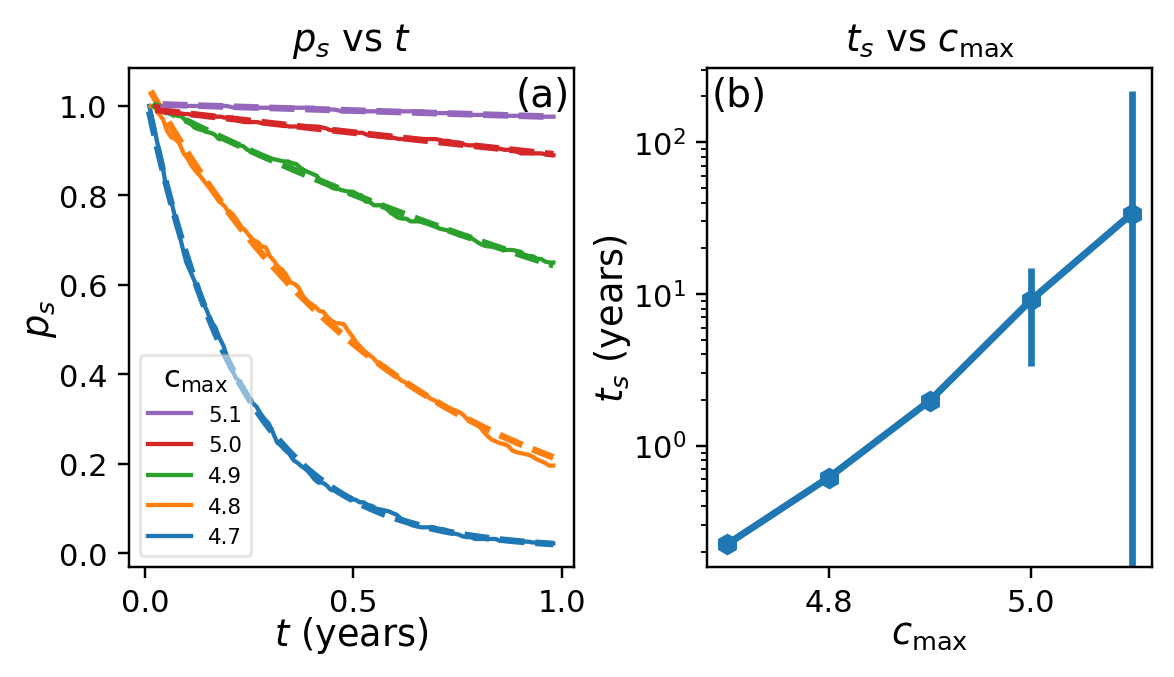

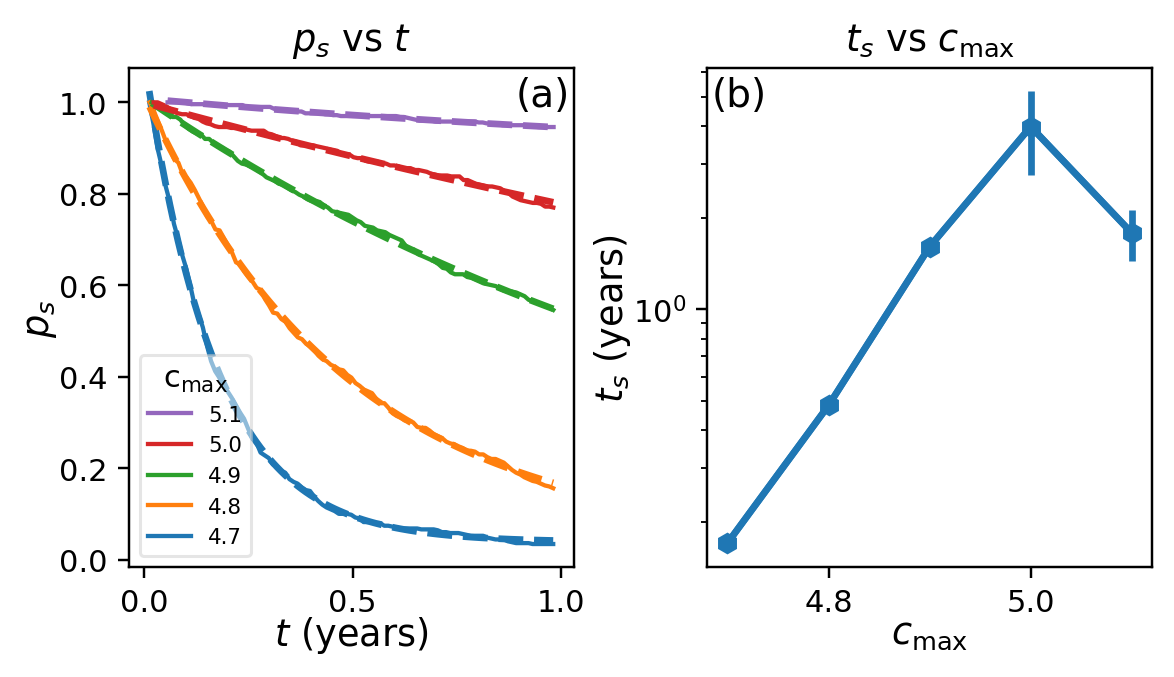

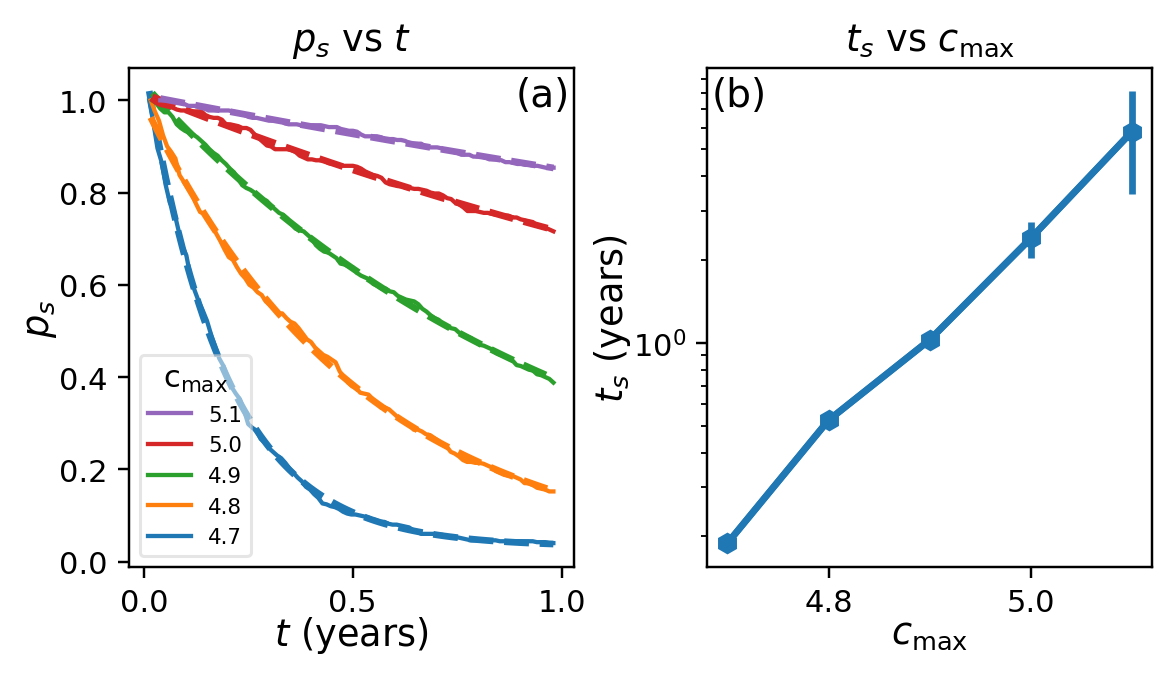

In [13]:
plot_fitSlopes_and_failRate(ttf_14pcres, cmax_vals, "ttf_plots_14pcres")
plot_fitSlopes_and_failRate(ttf_15pcres, cmax_vals, "ttf_plots_15pcres")
plot_fitSlopes_and_failRate(ttf_16pcres, cmax_vals, "ttf_plots_16pcres")

[1.02380086e+00 5.07811696e-04 7.60780015e-03]
[3.32717862e-03 3.42822251e-06 1.37519169e-03]

[1.05584299e+00 1.85602969e-04 1.92758851e-21]
[1.18373244e-02 5.58282982e-06 1.50001432e-02]

[9.43395452e-01 5.78631082e-05 7.00706058e-02]
[6.47692236e-02 5.25050468e-06 6.64428506e-02]

[9.93856983e-01 1.25901392e-05 1.61421253e-09]
[5.92030844e-01 7.94709570e-06 5.92737986e-01]

[1.00451492e+00 3.38166221e-06 2.04565004e-10]
[5.34839307e+00 1.82902656e-05 5.34888017e+00]



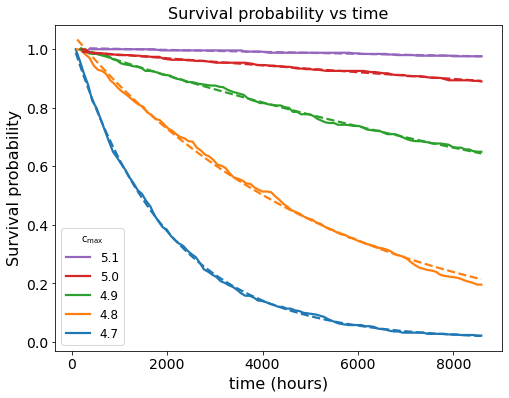

[1.06108473e+00 6.69416290e-04 3.83474364e-02]
[4.67792129e-03 4.69651500e-06 1.11775853e-03]

[9.77575051e-01 2.36217387e-04 3.92156481e-02]
[3.58032983e-03 2.91083315e-06 4.78027470e-03]

[1.01033881e+00 7.11563385e-05 8.48094095e-18]
[3.73358646e-02 3.72256548e-06 3.88063220e-02]

[9.99530836e-01 2.86611241e-05 9.11314357e-11]
[2.69839037e-01 8.84775782e-06 2.71523711e-01]

[1.47540827e-01 6.40946242e-05 8.60763247e-01]
[2.06039369e-02 1.24164585e-05 2.13733605e-02]



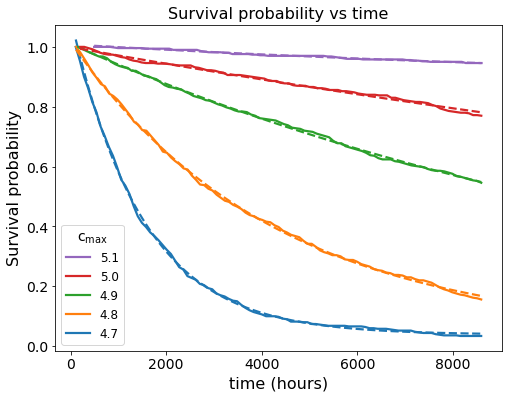

[1.05621118e+00 6.05352551e-04 3.21466314e-02]
[4.17168017e-03 4.13601394e-06 1.19501161e-03]

[9.93009968e-01 2.17402741e-04 5.20865292e-24]
[5.16026197e-03 3.58208748e-06 6.89148202e-03]

[1.03532860e+00 1.11450482e-04 3.31554193e-19]
[1.58497659e-02 3.01831717e-06 1.74543113e-02]

[8.77894154e-01 4.78457991e-05 1.37311765e-01]
[1.03280095e-01 7.07047622e-06 1.05088161e-01]

[1.01074051e+00 1.97035726e-05 3.95057264e-10]
[3.71966675e-01 7.95656350e-06 3.73121305e-01]



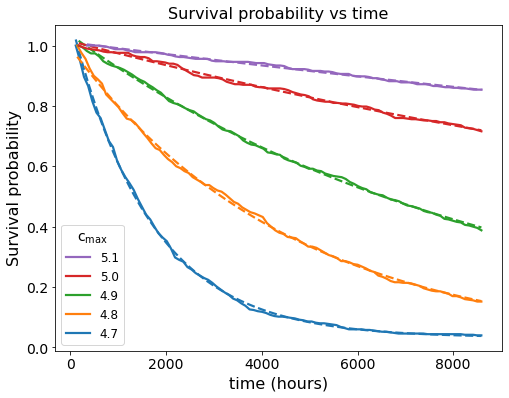

In [14]:
fitted_slopes_14pcres = fit_and_plot_survival_slope(ttf_14pcres, cmax_vals)
fitted_slopes_15pcres = fit_and_plot_survival_slope(ttf_15pcres, cmax_vals)
fitted_slopes_16pcres = fit_and_plot_survival_slope(ttf_16pcres, cmax_vals)

(0.000507811696214753, 0.00018560296911778967, 5.7863108178924834e-05, 1.2590139169512479e-05, 3.381662206412827e-06)
(3.4282225119094547e-06, 5.582829821626208e-06, 5.25050468285498e-06, 7.947095700632413e-06, 1.8290265644073117e-05)
[0.006750971939920941, 0.030079420863591697, 0.09074010795651213, 0.6312158740768029, 5.408661340978501]
[0.0015176076151765874, 0.01850037129899906, 0.17901665047713486, 5.723257357175205, 182.5809486672403]
[0.0015176076151765872, 0.018500371298999056, 0.1790166504771348, 5.723257357175205, 182.5809486672403]


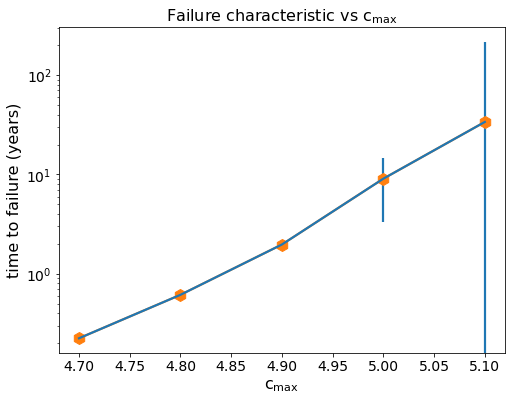

(0.0006694162898723309, 0.00023621738672826494, 7.115633852512752e-05, 2.866112412279026e-05, 6.409462423252473e-05)
(4.696515003504827e-06, 2.910833154252616e-06, 3.722565482685539e-06, 8.847757824898834e-06, 1.2416458533816959e-05)
[0.007015836146444138, 0.012322687989098458, 0.052315304017097296, 0.308702400749991, 0.19372074776149859]
[0.0011964073019765575, 0.00595510585235937, 0.08392880792354838, 1.229540053441026, 0.3450248890112281]
[0.0011964073019765573, 0.00595510585235937, 0.08392880792354837, 1.2295400534410257, 0.3450248890112281]


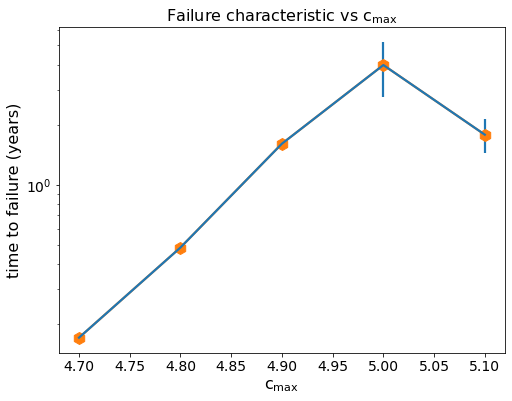

(0.0006053525506684555, 0.00021740274126369014, 0.00011145048168585884, 4.7845799118730024e-05, 1.9703572603398037e-05)
(4.136013939181797e-06, 3.582087484919257e-06, 3.018317173191187e-06, 7.070476215963652e-06, 7.956563499302248e-06)
[0.0068324052399129035, 0.01647673559265062, 0.02708213663623995, 0.1477763219800795, 0.40381324034251914]
[0.001288430907248773, 0.008651711927084752, 0.0277393875952362, 0.3525794000545198, 2.339545360298493]
[0.0012884309072487728, 0.008651711927084752, 0.02773938759523619, 0.3525794000545197, 2.3395453602984935]


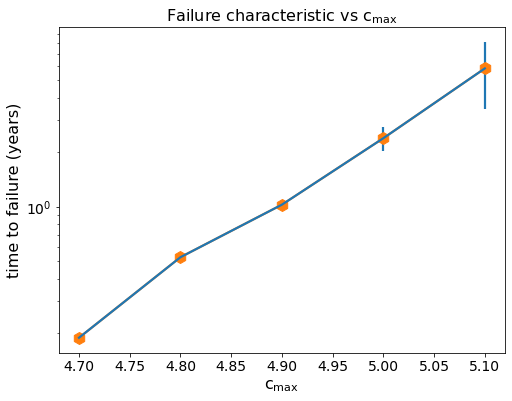

In [15]:
plot_characteristic_failure_rate(fitted_slopes_14pcres)
plot_characteristic_failure_rate(fitted_slopes_15pcres)
plot_characteristic_failure_rate(fitted_slopes_16pcres)